## Forecast load data with time series analyses

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

### Download data

In [3]:
start_date = '2021-01-01'
end_date = '2025-03-01'
list_years = [2021, 2022, 2023, 2024, 2025]
# Load data
df = pd.DataFrame()
for year in list_years:
    # the file name is Natuve_Load_year.csv
    file_name = '../Data/Hourly_Load_Data/Native_Load_' + str(year) + '.xlsx'
    df_year = pd.read_excel(file_name)
    df = pd.concat([df, df_year], axis=0)
    
df['Hour Ending'] = pd.to_datetime(df['Hour Ending'], format='%m/%d/%Y %H:%M', errors='coerce')
df = df.set_index('Hour Ending')

transform date to datetime, wich is tough because it does not support the 24h data type so we need to set to next day 00

In [4]:
mask = df.index.isnull()
indices = np.where(mask)[0]
index_list = list(df.index)

for i in indices:
    index_list[i] = index_list[i-1] + pd.DateOffset(hours=1)

# Assign the new index to the DataFrame
df.index = pd.Index(index_list)
df = df[~df.index.duplicated(keep='first')]
df

,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
2021-01-01 01:00:00,11047.018793,1517.435253,3978.220628,838.352810,13575.277728,3545.093310,7778.262533,1440.188560,43719.849616
2021-01-01 02:00:00,10954.470339,1523.683893,3975.757045,825.123437,13340.337915,3586.547882,7693.744119,1421.385715,43321.050347
2021-01-01 03:00:00,10883.657240,1519.800916,3969.812081,819.551228,13311.625189,3586.124059,7566.951524,1405.544826,43063.067063
2021-01-01 04:00:00,10926.482445,1523.472963,3983.487761,820.612439,13356.442066,3570.592369,7506.685527,1402.283632,43090.059203
2021-01-01 05:00:00,11019.796399,1565.625573,3980.940744,831.607158,13528.651487,3590.902242,7563.971854,1405.094618,43486.590073
...,...,...,...,...,...,...,...,...,...
2025-02-28 20:00:00,12289.742410,1501.370812,7027.478214,1414.692447,12569.901268,3947.643796,7510.979019,1150.660258,47412.468224
2025-02-28 21:00:00,12089.500362,1480.264262,7097.979335,1431.445778,12383.934355,3804.225323,7342.852199,1130.135315,46760.336929
2025-02-28 22:00:00,11940.877875,1460.269123,7142.270350,1437.538915,12127.386883,3742.182544,7103.414392,1112.107979,46066.048061
2025-02-28 23:00:00,11556.222543,1382.366295,7079.711434,1390.959677,11548.852838,3653.597969,6761.647003,1100.167564,44473.525322


### Line plots

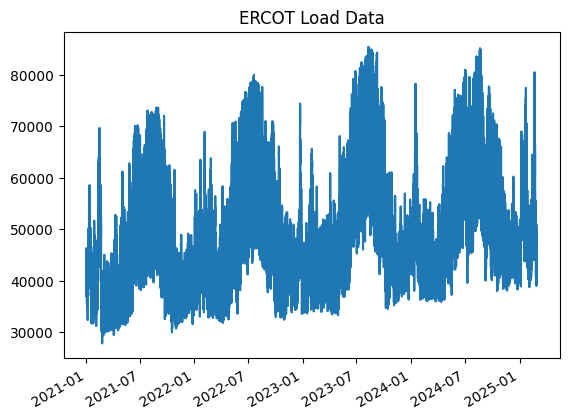

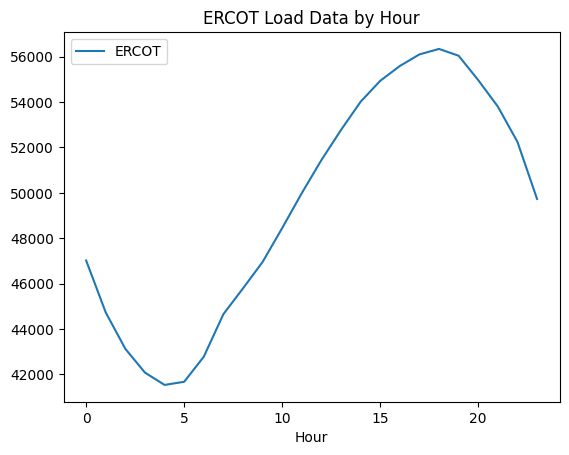

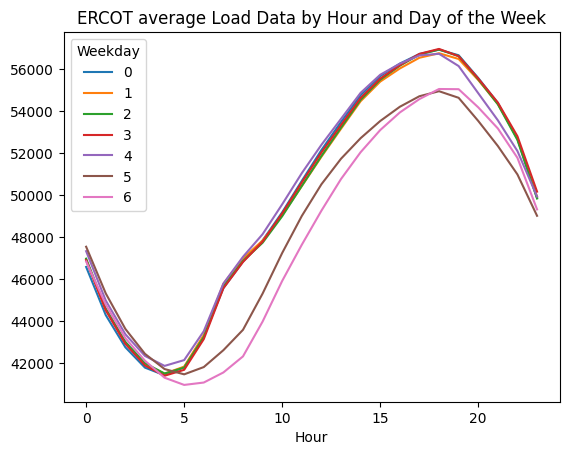

In [42]:
## plot data for the 4 years, for 1 year, and for 1 month
df.plot(y='ERCOT', kind='line', legend=False)
plt.title('ERCOT Load Data')
plt.show()
## plot average montly data for the 4 years
df['Month'] = df.index.month.copy()
df['Year'] = df.index.year.copy()
df['Day'] = df.index.day.copy()
df['Hour'] = df.index.hour.copy()

## plot grouped by hour data
df_hourly = df.groupby('Hour').mean().copy()
df_hourly.plot(y='ERCOT', kind='line')
plt.title('ERCOT Load Data by Hour')
plt.show()

## plot average by hour for each day of the week
df['Weekday'] = df.index.weekday.copy()
df_weekday_hourly = df.groupby(['Weekday', 'Hour']).mean().copy()
df_weekday_hourly = df_weekday_hourly.reset_index()
df_weekday_hourly = df_weekday_hourly.pivot(index='Hour', columns='Weekday', values='ERCOT')
df_weekday_hourly.plot(kind='line')
plt.title('ERCOT average Load Data by Hour and Day of the Week')
plt.show()

We see a clear seasonality withing the yean and within the day.

## Time series analysis:

A time series model could be relevant. We use Prohet, a library developed by Meta for time series. Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well

### Seasonal plots

Used for pattern recognition, forecasting, anomality detection, optimized decision-making

In [18]:
df_ercot = df[['ERCOT']].copy()
df_ercot.index = pd.to_datetime(df_ercot.index)

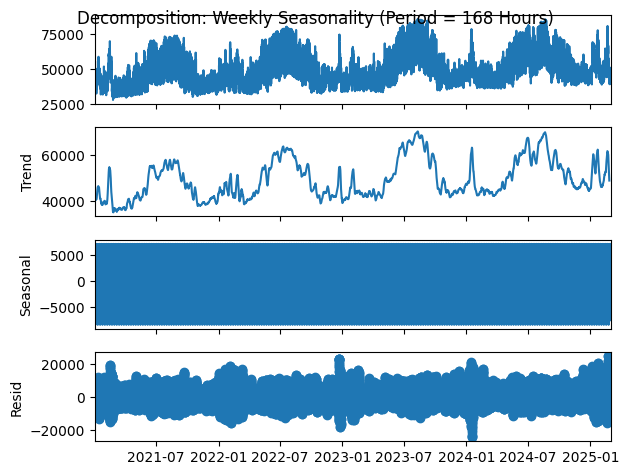

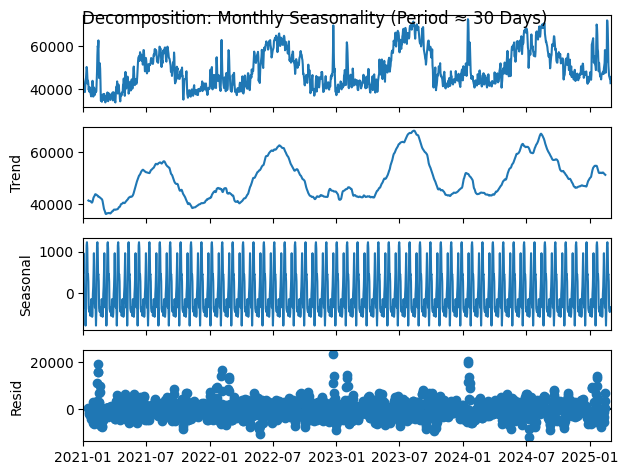

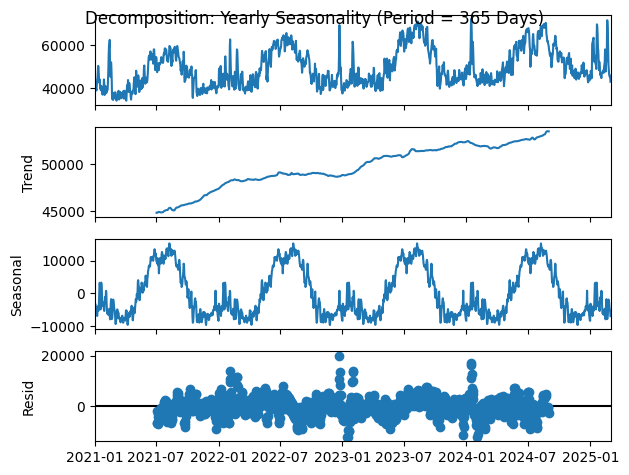

In [20]:
# ----- Weekly Seasonality (168 hours) -----
decomp_weekly = seasonal_decompose(df_ercot, model='additive', period=168)
decomp_weekly.plot()
plt.suptitle('Decomposition: Weekly Seasonality (Period = 168 Hours)')
plt.show()

# For longer-term trends, it's often useful to look at daily aggregated data.
ercot_daily = df_ercot.resample('D').mean()

# ----- Monthly Seasonality (approximate period of 30 days) -----
decomp_monthly = seasonal_decompose(ercot_daily, model='additive', period=30)
decomp_monthly.plot()
plt.suptitle('Decomposition: Monthly Seasonality (Period ≈ 30 Days)')
plt.show()

# ----- Yearly Seasonality (365 days) -----
decomp_yearly = seasonal_decompose(ercot_daily, model='additive', period=365)
decomp_yearly.plot()
plt.suptitle('Decomposition: Yearly Seasonality (Period = 365 Days)')
plt.show()

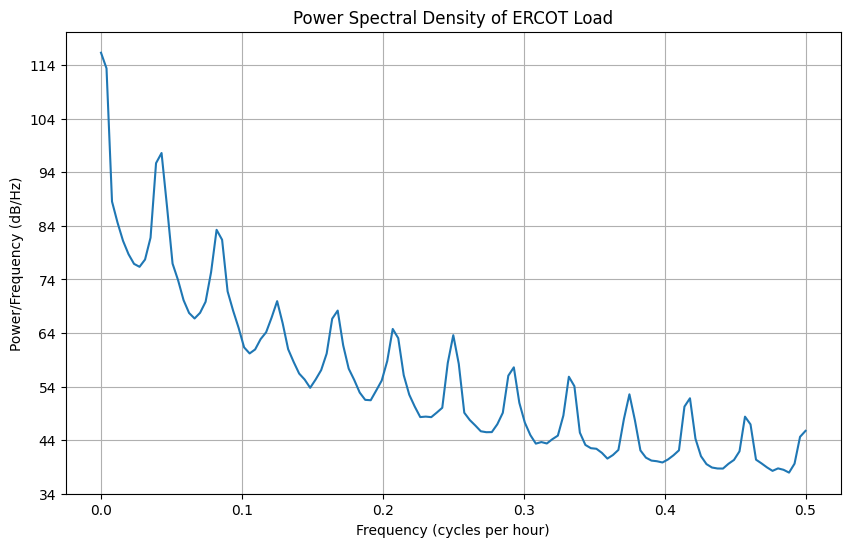

In [26]:
plt.figure(figsize=(10, 6))
plt.psd(df_ercot['ERCOT'], NFFT=256, Fs=1)  # NFFT: length of each segment for FFT calculation
plt.title('Power Spectral Density of ERCOT Load')
plt.xlabel('Frequency (cycles per hour)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()

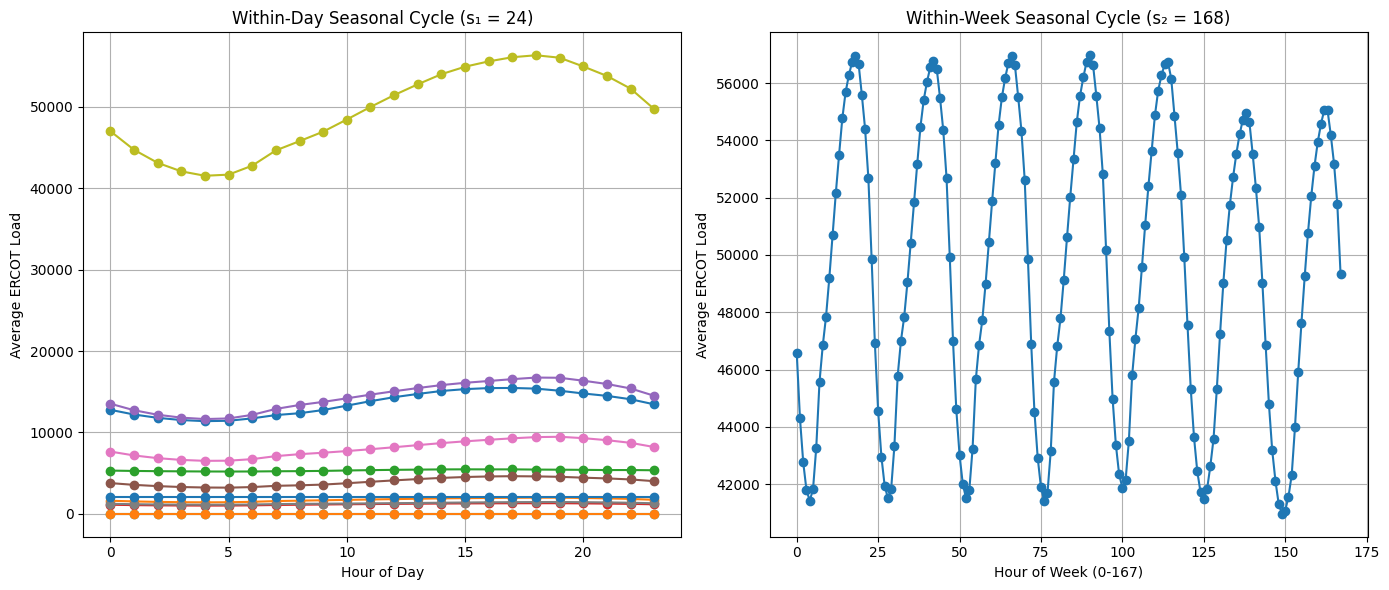

In [8]:


# Compute the average load for each hour of the day
daily_seasonality = df_hourly.copy()

# --- Within-Week Seasonal Cycle (s₂ = 168) ---
# Create a column for day of week (Monday=0, Sunday=6)
df['DayOfWeek'] = df.index.dayofweek
# Create a new column "HourOfWeek": combine day and hour so that
# Monday 0:00 is 0, Monday 1:00 is 1, ..., Sunday 23:00 is 167.
df['HourOfWeek'] = df['DayOfWeek'] * 24 + df.index.hour

# Compute the average load for each hour of the week
weekly_seasonality = df.groupby('HourOfWeek')['ERCOT'].mean()

# --- Plotting ---
plt.figure(figsize=(14, 6))

# Plot within-day seasonality
plt.subplot(1, 2, 1)
plt.plot(daily_seasonality.index, daily_seasonality.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average ERCOT Load')
plt.title('Within-Day Seasonal Cycle (s₁ = 24)')
plt.grid(True)

# Plot within-week seasonality
plt.subplot(1, 2, 2)
plt.plot(weekly_seasonality.index, weekly_seasonality.values, marker='o')
plt.xlabel('Hour of Week (0-167)')
plt.ylabel('Average ERCOT Load')
plt.title('Within-Week Seasonal Cycle (s₂ = 168)')
plt.grid(True)

plt.tight_layout()
plt.show()


### Plot PACF to find the time series parameters p,q,d

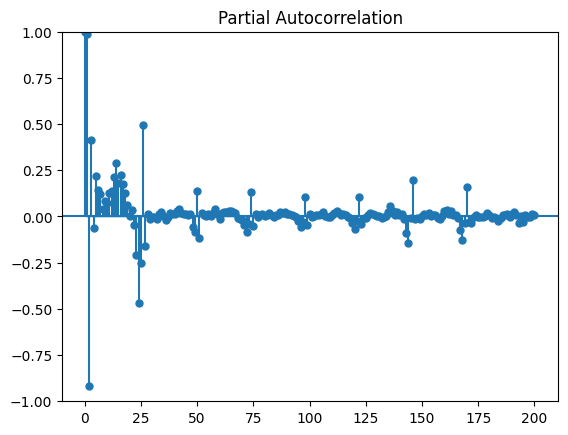

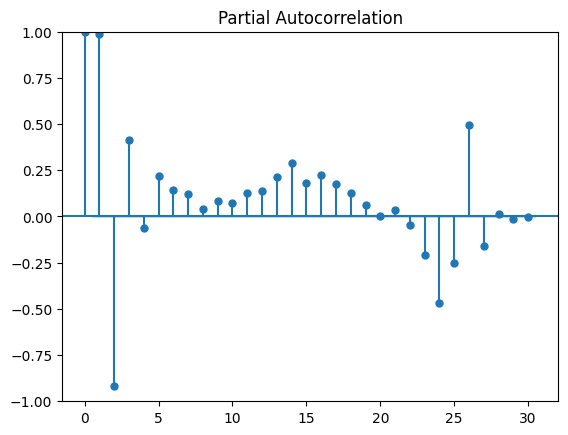

In [ ]:
## Plot PACF to find the time series parameters p,q,d
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['ERCOT'], lags=100)
plt.show()

plot_pacf(df['ERCOT'], lags=200)
plt.show()

plot_pacf(df['ERCOT'], lags=30)
plt.show()

## get paramers p, d, q with the PACF plot

the PACF shows how much correlated the time series is with its past-values. We see a high value for 1 and 2 (short run dependence) as well as an increase around 25 (daily) and around 170 (monthly seasonality).

It is hard to determine p (the order at which the pacf values should be very low) as it does not decrease fast

In [46]:
regions = ['COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT']
## training dataset (up to 2024)
train = df.loc[:'2023-12-31']
prophet_df = pd.DataFrame({
            'ds': train.index,
            'y': train['ERCOT']
        })
m = Prophet()
m.fit(prophet_df)

15:35:06 - cmdstanpy - INFO - Chain [1] start processing
15:35:23 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
train.head()

,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
2021-01-01 01:00:00,11047.018793,1517.435253,3978.220628,838.352810,13575.277728,3545.093310,7778.262533,1440.188560,43719.849616
2021-01-01 02:00:00,10954.470339,1523.683893,3975.757045,825.123437,13340.337915,3586.547882,7693.744119,1421.385715,43321.050347
2021-01-01 03:00:00,10883.657240,1519.800916,3969.812081,819.551228,13311.625189,3586.124059,7566.951524,1405.544826,43063.067063
2021-01-01 04:00:00,10926.482445,1523.472963,3983.487761,820.612439,13356.442066,3570.592369,7506.685527,1402.283632,43090.059203
2021-01-01 05:00:00,11019.796399,1565.625573,3980.940744,831.607158,13528.651487,3590.902242,7563.971854,1405.094618,43486.590073


,ds
0,2021-01-01 01:00:00
1,2021-01-01 02:00:00
2,2021-01-01 03:00:00
3,2021-01-01 04:00:00
4,2021-01-01 05:00:00
...,...
43575,2025-12-21 20:00:00
43576,2025-12-21 21:00:00
43577,2025-12-21 22:00:00
43578,2025-12-21 23:00:00


,ds,yhat,yhat_lower,yhat_upper
43575,2025-12-21 20:00:00,58956.561798,21682.184717,92574.010224
43576,2025-12-21 21:00:00,57649.341896,19657.035543,90877.827668
43577,2025-12-21 22:00:00,55790.317260,17652.368317,88959.982186
43578,2025-12-21 23:00:00,53529.165855,15690.314814,87530.212805
43579,2025-12-22 00:00:00,51113.125065,14225.052020,85041.801852


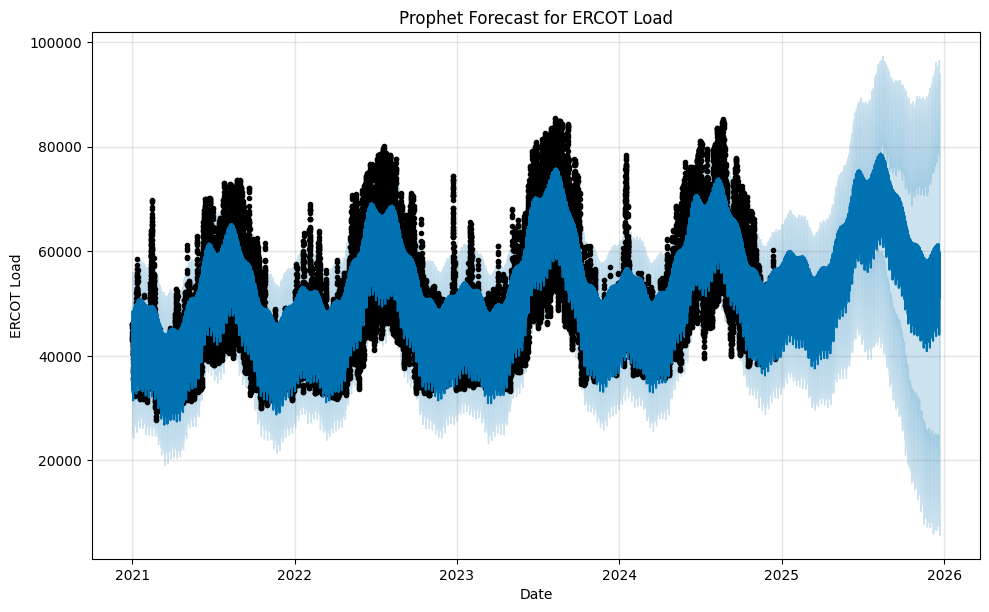

In [43]:
## predict each hour of 2024
future = m.make_future_dataframe(periods=365*24, freq='h')
display(future)

forecast = m.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

fig1 = m.plot(forecast, xlabel='Date', ylabel='ERCOT Load')
plt.title('Prophet Forecast for ERCOT Load')
plt.show()

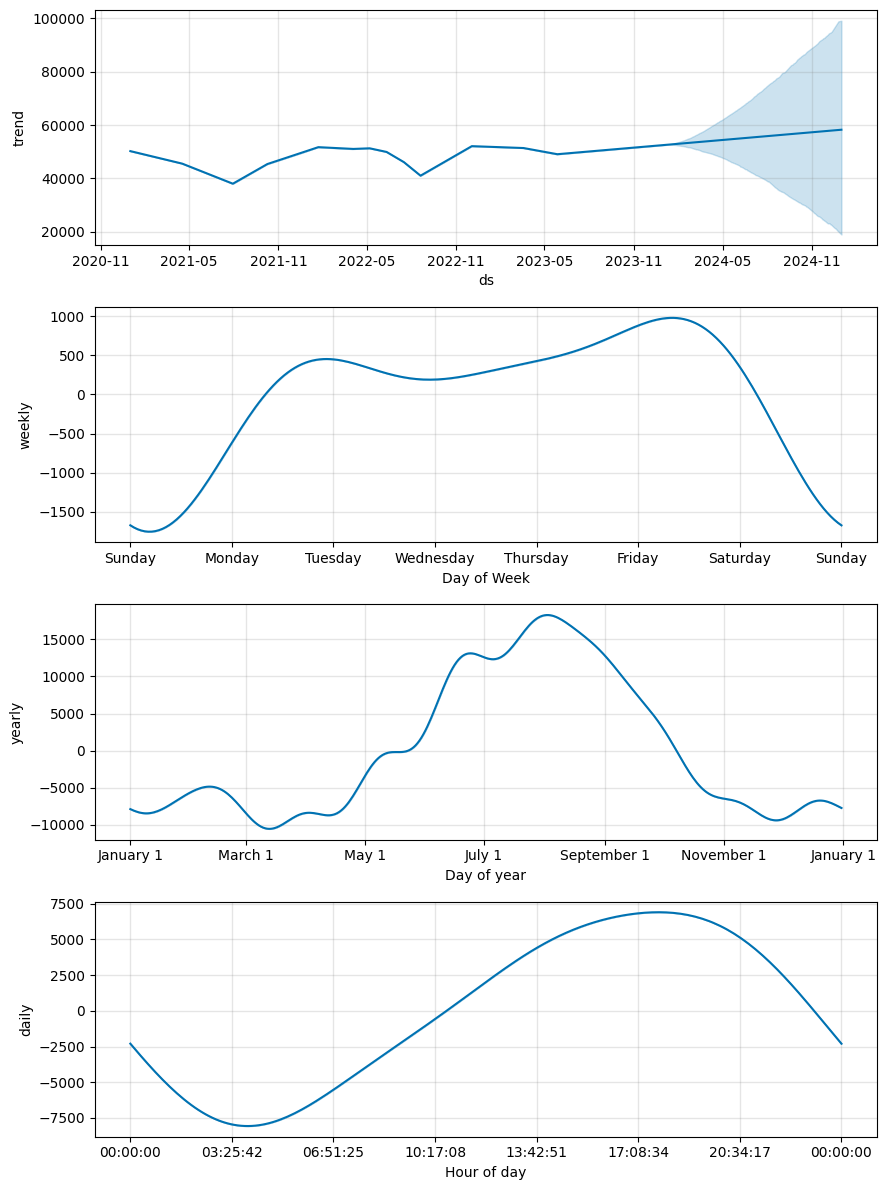

In [84]:
fig2 = m.plot_components(forecast)


The trend over the years is negligeable. We see a strong impact of the day of the week, hour of the day and month of the year impact though. we have daily, weekly and annually seasonality

Training error rate: 1834.62%
Test error rate: 9.33%
Mean of residuals: -2811.5411317267653
95% confidence interval: (-16333.547448885627, 10710.465185432098)
Mean error rate: 10.67%
Standard deviation of error rate: 9.33%


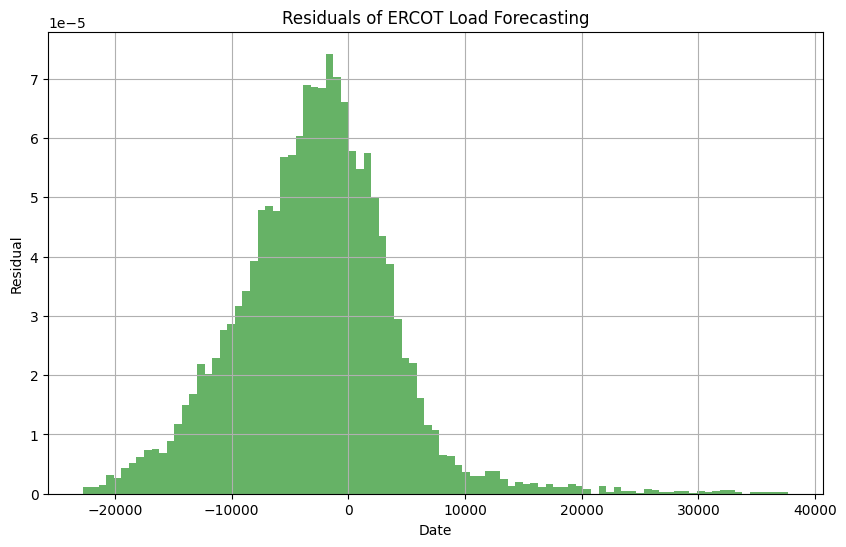

In [126]:
## prediction error as a % on the training dataset
y_true = train['ERCOT']
y_pred = forecast.set_index('ds').loc[train.index, 'yhat']
mae = np.linalg.norm(y_true - y_pred)
train_error_rate = 100 * mae / np.mean(y_true)
print(f'Training error rate: {train_error_rate:.2f}%')

## prediction error as a % on the test dataset

forecasted_val = forecast[forecast['ds'] >= '2024-01-01'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
y_true = df.loc['2024-01-01':forecasted_val.index[-1]]
y_true = y_true['ERCOT']
y_pred = forecasted_val['yhat']
residual = (y_true - y_pred).dropna()
mae = np.std(np.abs(residual))
test_error_rate = 100 * mae / np.mean(y_true)
print(f'Test error rate: {test_error_rate:.2f}%')

## get Confidence Interval
mean = np.mean(residual)
print(f'Mean of residuals: {mean}')
std = np.std(residual)
confidence_interval = (mean - 1.96 * std, mean + 1.96 * std)
print(f'95% confidence interval: {confidence_interval}')

mean_error_rate = 100 * np.mean(np.abs(residual)) / np.mean(y_true)
print(f'Mean error rate: {mean_error_rate:.2f}%')
std_error_rate = 100 * np.std(np.abs(residual)) / np.mean(y_true)
print(f'Standard deviation of error rate: {std_error_rate:.2f}%')

## plot residuals
plt.figure(figsize=(10, 6))
plt.hist(residual.values, bins = int(np.sqrt(len(residual))), density=True, alpha=0.6, color='g')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals of ERCOT Load Forecasting')
plt.grid(True)
plt.show()



Prophet is a good alternative to traditional time series as it finds by itself the trend, seasonality and cycles without incorporating the parameters (for SARIMA model) 

## create a forecasted load dataset

during the 2024 year, each week we create the next week forecast based on all available data

In [54]:
start_date = '2023-12-23'
end_date = '2025-01-07'
## create a list of dates with weekly frequency
date_list = pd.date_range(start=start_date, end=end_date, freq='W')

# during the 2024 year, each week we create the next week forecast based on all available data
forecasted_val = pd.DataFrame()
for i in range(len(date_list)-1):
    print(i)
    train = df.loc[:date_list[i]-pd.Timedelta(1, unit='D')]
    prophet_df = pd.DataFrame({
        'ds': train.index,
        'y': train['ERCOT']
    })
    m = Prophet()
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=168, freq='h')
    forecast = m.predict(future)
    forecasted_val = pd.concat([forecasted_val, forecast[forecast['ds'] >= date_list[i]],], axis=0)
    

0


03:57:25 - cmdstanpy - INFO - Chain [1] start processing
03:57:38 - cmdstanpy - INFO - Chain [1] done processing


1


03:57:45 - cmdstanpy - INFO - Chain [1] start processing
03:58:02 - cmdstanpy - INFO - Chain [1] done processing


2


03:58:11 - cmdstanpy - INFO - Chain [1] start processing
03:58:29 - cmdstanpy - INFO - Chain [1] done processing


3


03:58:37 - cmdstanpy - INFO - Chain [1] start processing
03:58:49 - cmdstanpy - INFO - Chain [1] done processing


4


03:58:57 - cmdstanpy - INFO - Chain [1] start processing
03:59:09 - cmdstanpy - INFO - Chain [1] done processing


5


03:59:17 - cmdstanpy - INFO - Chain [1] start processing
03:59:28 - cmdstanpy - INFO - Chain [1] done processing


6


03:59:37 - cmdstanpy - INFO - Chain [1] start processing
03:59:53 - cmdstanpy - INFO - Chain [1] done processing


7


03:59:58 - cmdstanpy - INFO - Chain [1] start processing
04:00:11 - cmdstanpy - INFO - Chain [1] done processing


8


04:00:20 - cmdstanpy - INFO - Chain [1] start processing
04:00:31 - cmdstanpy - INFO - Chain [1] done processing


9


04:00:38 - cmdstanpy - INFO - Chain [1] start processing
04:00:54 - cmdstanpy - INFO - Chain [1] done processing


10


04:01:01 - cmdstanpy - INFO - Chain [1] start processing
04:01:20 - cmdstanpy - INFO - Chain [1] done processing


11


04:01:26 - cmdstanpy - INFO - Chain [1] start processing
04:01:42 - cmdstanpy - INFO - Chain [1] done processing


12


04:01:50 - cmdstanpy - INFO - Chain [1] start processing
04:02:07 - cmdstanpy - INFO - Chain [1] done processing


13


04:02:14 - cmdstanpy - INFO - Chain [1] start processing
04:02:24 - cmdstanpy - INFO - Chain [1] done processing


14


04:02:30 - cmdstanpy - INFO - Chain [1] start processing
04:02:42 - cmdstanpy - INFO - Chain [1] done processing


15


04:02:48 - cmdstanpy - INFO - Chain [1] start processing
04:02:59 - cmdstanpy - INFO - Chain [1] done processing


16


04:03:06 - cmdstanpy - INFO - Chain [1] start processing
04:03:17 - cmdstanpy - INFO - Chain [1] done processing


17


04:03:22 - cmdstanpy - INFO - Chain [1] start processing
04:03:36 - cmdstanpy - INFO - Chain [1] done processing


18


04:03:42 - cmdstanpy - INFO - Chain [1] start processing
04:04:00 - cmdstanpy - INFO - Chain [1] done processing


19


04:04:06 - cmdstanpy - INFO - Chain [1] start processing
04:04:25 - cmdstanpy - INFO - Chain [1] done processing


20


04:04:34 - cmdstanpy - INFO - Chain [1] start processing
04:04:56 - cmdstanpy - INFO - Chain [1] done processing


21


04:05:02 - cmdstanpy - INFO - Chain [1] start processing
04:05:18 - cmdstanpy - INFO - Chain [1] done processing


22


04:05:24 - cmdstanpy - INFO - Chain [1] start processing
04:05:40 - cmdstanpy - INFO - Chain [1] done processing


23


04:05:46 - cmdstanpy - INFO - Chain [1] start processing
04:06:05 - cmdstanpy - INFO - Chain [1] done processing


24


04:06:10 - cmdstanpy - INFO - Chain [1] start processing
04:06:21 - cmdstanpy - INFO - Chain [1] done processing


25


04:06:27 - cmdstanpy - INFO - Chain [1] start processing
04:06:40 - cmdstanpy - INFO - Chain [1] done processing


26


04:06:45 - cmdstanpy - INFO - Chain [1] start processing
04:06:58 - cmdstanpy - INFO - Chain [1] done processing


27


04:07:03 - cmdstanpy - INFO - Chain [1] start processing
04:07:21 - cmdstanpy - INFO - Chain [1] done processing


28


04:07:26 - cmdstanpy - INFO - Chain [1] start processing
04:07:40 - cmdstanpy - INFO - Chain [1] done processing


29


04:07:46 - cmdstanpy - INFO - Chain [1] start processing
04:08:00 - cmdstanpy - INFO - Chain [1] done processing


30


04:08:06 - cmdstanpy - INFO - Chain [1] start processing
04:08:24 - cmdstanpy - INFO - Chain [1] done processing


31


04:08:30 - cmdstanpy - INFO - Chain [1] start processing
04:08:48 - cmdstanpy - INFO - Chain [1] done processing


32


04:08:53 - cmdstanpy - INFO - Chain [1] start processing
04:09:11 - cmdstanpy - INFO - Chain [1] done processing


33


04:09:18 - cmdstanpy - INFO - Chain [1] start processing
04:09:35 - cmdstanpy - INFO - Chain [1] done processing


34


04:09:41 - cmdstanpy - INFO - Chain [1] start processing
04:09:55 - cmdstanpy - INFO - Chain [1] done processing


35


04:10:01 - cmdstanpy - INFO - Chain [1] start processing
04:10:21 - cmdstanpy - INFO - Chain [1] done processing


36


04:10:26 - cmdstanpy - INFO - Chain [1] start processing
04:10:47 - cmdstanpy - INFO - Chain [1] done processing


37


04:10:53 - cmdstanpy - INFO - Chain [1] start processing
04:11:17 - cmdstanpy - INFO - Chain [1] done processing


38


04:11:25 - cmdstanpy - INFO - Chain [1] start processing
04:11:51 - cmdstanpy - INFO - Chain [1] done processing


39


04:12:00 - cmdstanpy - INFO - Chain [1] start processing
04:12:16 - cmdstanpy - INFO - Chain [1] done processing


40


04:12:27 - cmdstanpy - INFO - Chain [1] start processing
04:12:43 - cmdstanpy - INFO - Chain [1] done processing


41


04:12:50 - cmdstanpy - INFO - Chain [1] start processing
04:13:06 - cmdstanpy - INFO - Chain [1] done processing


42


04:13:13 - cmdstanpy - INFO - Chain [1] start processing
04:13:27 - cmdstanpy - INFO - Chain [1] done processing


43


04:13:35 - cmdstanpy - INFO - Chain [1] start processing
04:13:57 - cmdstanpy - INFO - Chain [1] done processing


44


04:14:05 - cmdstanpy - INFO - Chain [1] start processing
04:14:29 - cmdstanpy - INFO - Chain [1] done processing


45


04:14:37 - cmdstanpy - INFO - Chain [1] start processing
04:14:50 - cmdstanpy - INFO - Chain [1] done processing


46


04:14:56 - cmdstanpy - INFO - Chain [1] start processing
04:15:15 - cmdstanpy - INFO - Chain [1] done processing


47


04:15:22 - cmdstanpy - INFO - Chain [1] start processing
04:15:45 - cmdstanpy - INFO - Chain [1] done processing


48


04:15:54 - cmdstanpy - INFO - Chain [1] start processing
04:16:09 - cmdstanpy - INFO - Chain [1] done processing


49


04:16:15 - cmdstanpy - INFO - Chain [1] start processing
04:16:32 - cmdstanpy - INFO - Chain [1] done processing


50


04:16:39 - cmdstanpy - INFO - Chain [1] start processing
04:16:55 - cmdstanpy - INFO - Chain [1] done processing


51


04:17:01 - cmdstanpy - INFO - Chain [1] start processing
04:17:15 - cmdstanpy - INFO - Chain [1] done processing


52


04:17:21 - cmdstanpy - INFO - Chain [1] start processing
04:17:42 - cmdstanpy - INFO - Chain [1] done processing


53


04:17:48 - cmdstanpy - INFO - Chain [1] start processing
04:18:10 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
## store data in parquet file
forecasted_val.to_parquet('C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/Power_Market-1/Data/forecasted_load.parquet')